## Install dependencies

In [1]:
%pip install -q lightning wandb torchvision torchmetrics matplotlib

Note: you may need to restart the kernel to use updated packages.


## Import packages

In [2]:
from pathlib import Path
import time

import PIL.Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.v2 as v2
import torchmetrics
import lightning as L
import wandb
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger

import matplotlib.pyplot as plt

from jassair.utils import get_dataset_path, Datasets

## Lower matmul precision

## WandB login for experiment tracking

In [3]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: schurtenberger-david (david-schurtenberger) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Global variable definition

In [4]:
DATA_DIR = get_dataset_path(Datasets.S_1TO1_36C_NOVLP)
BATCH_SIZE = 32
NUM_CLASSES = 36

## Custom Synth-data Dataset

In [5]:
class YoloStyleDataset(Dataset):
    def __init__(self, root_dir: Path, transform=None):
        self.root_dir = root_dir
        self.image_dir = root_dir / 'images'
        self.label_dir = root_dir / 'labels'
        self.transform = transform
        self.image_files: list[Path] = [f for f in self.image_dir.iterdir()]
        self.labels: list[int] = []
        for file in self.image_files:
            label_file = self.label_dir / f"{file.stem}.txt"
            with label_file.open("r", encoding="utf-8") as f:
                self.labels.append(int(f.readline().split()[0]))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path: Path = self.image_files[idx]
        label = self.labels[idx]
        image = PIL.Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

## Baseline Model

In [6]:
class ImageClassifier(L.LightningModule):
    def __init__(self, lr: float, weight_decay: float, finetune_only: bool):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = MODEL
        
        # If set, only train the newly attached FC layer
        if self.hparams.finetune_only:
            for param in self.model.parameters():
                param.requires_grad = False

        match self.model._get_name().lower():
            case "efficientnet":
                in_features = self.model.classifier[1].in_features
                self.model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
            case "resnet":
                in_features = self.model.fc.in_features
                self.model.fc = nn.Linear(in_features, NUM_CLASSES)

        self.criterion = nn.CrossEntropyLoss()
        
        self._train_acc = torchmetrics.Accuracy("multiclass", num_classes=NUM_CLASSES)
        self._train_loss = []
        self._valid_acc = torchmetrics.Accuracy("multiclass", num_classes=NUM_CLASSES)
        self._valid_loss = []
        self._test_preds = []
        self._test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self._train_acc(outputs, labels)
        self._train_loss.append(loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self._valid_acc(outputs, labels)
        self._valid_loss.append(loss)
        
    def on_train_epoch_end(self):
        loss = torch.stack(self._train_loss).mean()
        self.log_dict({'train_loss': loss, 'train_acc': self._train_acc.compute()}, prog_bar=True)
        self._train_loss.clear()
        self._train_acc.reset()

    def on_validation_epoch_end(self):
        loss = torch.stack(self._valid_loss).mean()
        self.log_dict({'val_loss': loss, 'val_acc': self._valid_acc.compute()}, prog_bar=True)
        self._valid_loss.clear()
        self._valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)

        self._test_preds.append(preds.detach().cpu())
        self._test_labels.append(y.detach().cpu())

        return {}

    def on_test_epoch_end(self):
        preds = torch.cat(self._test_preds)
        targets = torch.cat(self._test_labels)

        cm = self._confusion_matrix(preds, targets)

        precision = []
        recall = []
        f1 = []

        for i in range(NUM_CLASSES):
            true_positives = cm[i, i].item()
            false_positives = cm[:, i].sum().item() - true_positives
            false_negatives = cm[i, :].sum().item() - true_positives

            _precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
            _recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
            _f1 = 2 * _precision * _recall / (_precision + _recall) if (_precision + _recall) > 0 else 0.0

            precision.append(_precision)
            recall.append(_recall)
            f1.append(_f1)

            self.log(f'test/precision_class_{i}', _precision)
            self.log(f'test/recall_class_{i}', _recall)
            self.log(f'test/f1_class_{i}', _f1)

        # Overall Accuracy
        acc = (preds == targets).sum().item() / len(targets)
        self.log('test/accuracy', acc)

        # Macro averages
        self.log('test/macro_precision', sum(precision) / NUM_CLASSES)
        self.log('test/macro_recall', sum(recall) / NUM_CLASSES)
        self.log('test/macro_f1', sum(f1) / NUM_CLASSES)

    def _confusion_matrix(self, preds, targets):
        cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int32)
        for t, p in zip(targets, preds):
            cm[t, p] += 1
        return cm

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, self.hparams.lr / 1000, self.hparams.lr)
        return [optimizer], [scheduler]

#### Training routine

In [7]:
def get_run_name(config, ft=False):
    params = []
    for k, v in config.items():
        if isinstance(v, float):
            params.append(f"{k}{v:.4f}")
        else:
            params.append(f"{k}{v}")
    return f"{MODEL_NAME}_{'_'.join(params)}_ft{ft}{time.strftime('%y%m%d%H%M%S')}"

In [8]:
def train_classifier(config, logger, *callbacks):
    L.seed_everything(42)
    model = ImageClassifier(
        wandb.config.get("lr"), 
        wandb.config.get("wd"),
        wandb.config.get("ft_only"),
    )
    trainer = L.Trainer(
        callbacks=list(callbacks),
        max_epochs=wandb.config.get("epochs"),
        accelerator="auto",
        precision='16-mixed',
        logger=logger,
    )
    trainer.fit(model, train_loader, val_loader)

In [9]:
def wandb_train_run(run):
    config = wandb.config
    run.name = get_run_name(config)
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        dirpath="./lightning_checkpoints",
        filename=run.name + "_{epoch:02d}_{val_acc:.2f}",
        monitor="val_acc",
        save_last=True,
        mode="max"
    )
    early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
        min_delta=0.005, # Improve at least 0.5%
        monitor="val_acc",
        patience=5,
        mode="max",
    )
    wandb_logger = WandbLogger()
    train_classifier(config, wandb_logger, checkpoint_callback, early_stopping_callback)
    artifact = wandb.Artifact(run.name, "model")
    artifact.add_file(checkpoint_callback.best_model_path)
    wandb.log_artifact(artifact)

In [10]:
def plot_cm(predictions, labels, name):
    fig, ax = plt.subplots(figsize=(20, 20))
    cm = torchmetrics.ConfusionMatrix("multiclass", num_classes=36)
    cm.update(predictions, labels)
    cm.plot(ax=ax, labels=['Eichel 10', 'Eichel 6', 'Eichel 7', 'Eichel 8', 'Eichel 9', 'Eichel Ass', 'Eichel Konig', 'Eichel Ober', 'Eichel Under', 'Rose 10', 'Rose 6', 'Rose 7', 'Rose 8', 'Rose 9', 'Rose Ass', 'Rose Konig', 'Rose Ober', 'Rose Under', 'Schelle 10', 'Schelle 6', 'Schelle 7', 'Schelle 8', 'Schelle 9', 'Schelle Ass', 'Schelle Konig', 'Schelle Ober', 'Schelle Under', 'Schilte 10', 'Schilte 6', 'Schilte 7', 'Schilte 8', 'Schilte 9', 'Schilte Ass', 'Schilte Konig', 'Schilte Ober', 'Schilte Under'], cmap="plasma") 
    cbar = fig.colorbar(ax.images[0], ax=ax)
    plt.savefig(f"{name}.png", bbox_inches="tight")

In [11]:
def test_classifier(checkpoint, logger, name):
    L.seed_everything(42)
    model = ImageClassifier.load_from_checkpoint(checkpoint)
    trainer = L.Trainer(
        accelerator="auto",
        logger=logger,
    )
    trainer.test(model, test_loader)
    plot_cm(torch.cat(model._test_preds), torch.cat(model._test_labels), name)

In [12]:
def wandb_test_run(run, checkpoint):
    config = wandb.config
    run.name = get_run_name(config)
    wandb_logger = WandbLogger()
    test_classifier(checkpoint, wandb_logger, run.name)

In [13]:
def classifier_sweep(config=None):
    with wandb.init(config=config) as run:
        wandb_train_run(run)

## EfficientNet

#### Load model and weights

In [ ]:
MODEL_WEIGHTS = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
TRANSFORM = MODEL_WEIGHTS.transforms()
MODEL = models.efficientnet_v2_s(weights=MODEL_WEIGHTS)
MODEL_NAME = MODEL._get_name()

In [ ]:
print(f"TRANSFORM: {TRANSFORM}")

#### Data augmentation

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.RandomAffine(degrees=180, translate=(0.1, 0.1)),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    v2.Resize(384, interpolation=v2.InterpolationMode.BILINEAR),
    v2.ToDtype(torch.float32, scale=True),  # Converts to float [0,1]
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])
print(transform)

#### DataLoader

In [ ]:
train_dataset = YoloStyleDataset(DATA_DIR / "train", transform)
val_dataset = YoloStyleDataset(DATA_DIR / "valid", TRANSFORM)
test_dataset = YoloStyleDataset(DATA_DIR / "test", TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Sanity check
image, label = next(iter(test_loader))
print(f"Test Image shape: {image.shape}, Label: {label.shape}")

## Test run

In [ ]:
with wandb.init(
    entity="jassair",
    project="Baseline",
    config={
        "lr": 1e-2,
        "wd": 1e-6,
        "ft_only": True,
        "epochs": 50
    },
) as run:
    wandb_train_run(run)

## Hyperparameter Sweep

In [ ]:
sweep_config = {
    "name": "EffiecientNet-Sweep",
    "method": "grid",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "lr": {"values": [1e-3, 1e-2]},
        "wd": {"values": [1e-6, 1e-5, 1e-4]},
        "ft_only": {"value": True},
        "epochs": {"value": 50},
    }
}

In [ ]:
sweep_id = wandb.sweep(
    sweep=sweep_config, 
    entity="jassair",
    project="BaselineModel",
)

In [ ]:
wandb.agent(sweep_id=sweep_id, function=classifier_sweep)

In [ ]:
wandb.api.stop_sweep(sweep_id)

## ResNet

#### Load model and weights

In [ ]:
MODEL_WEIGHTS = models.ResNet50_Weights.IMAGENET1K_V2
TRANSFORM = MODEL_WEIGHTS.transforms()
MODEL = models.resnet50(weights=MODEL_WEIGHTS)
MODEL_NAME = MODEL._get_name()

In [ ]:
print(f"TRANSFORM: {TRANSFORM}")

## Data augmentation

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    v2.Resize(232, interpolation=v2.InterpolationMode.BILINEAR),
    v2.ToDtype(torch.float32, scale=True),  # Converts to float [0,1]
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])
print(transform)

#### Data loaders

In [ ]:
train_dataset = YoloStyleDataset(DATA_DIR / "train", transform=transform)
val_dataset = YoloStyleDataset(DATA_DIR / "valid", transform=TRANSFORM)
test_dataset = YoloStyleDataset(DATA_DIR / "test", transform=TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)

# Sanity check
image, label = train_dataset[1]
print(f"Train Image shape: {image.shape}, Label: {label}")
image, label = test_dataset[1]
print(f"Test Image shape: {image.shape}, Label: {label}")

In [ ]:
sweep_config = {
    "name": "ResNet-Sweep",
    "method": "random",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "lr": {"values": [1e-4, 1e-3, 1e-2]},
        "wd": {"values": [1e-6, 1e-5, 1e-4]},
        "ft_only": {"values": [True, False]},
        "epochs": {"value": 50},
    }
}

In [ ]:
sweep_id = wandb.sweep(
    sweep=sweep_config, 
    entity="jassair",
    project="BaselineModel",
)

In [ ]:
wandb.agent(sweep_id=sweep_id, function=classifier_sweep, count=6)

In [ ]:
wandb.api.stop_sweep(sweep_id)

### Evaluation

In [18]:
def run_tests(cps: list[str], test_set: str):
    config=dict(test=test_set)
    for checkpoint in cps:
        config["lr"] = checkpoint.split("=")[3][:-3]
        with wandb.init(entity="jassair", project="BaselineModel", config=config) as run:
            wandb_test_run(run, f"lightning_checkpoints/{checkpoint}")

#### ResNet

In [73]:
MODEL_WEIGHTS = models.ResNet50_Weights.IMAGENET1K_V2
TRANSFORM = MODEL_WEIGHTS.transforms()
MODEL = models.resnet50(weights=MODEL_WEIGHTS)
MODEL_NAME = MODEL._get_name()

In [74]:
checkpoints = [
    "ResNet_epochs=50_ft_only=True_lr=0.0100_wd=0.0000_ft=False250420051934_epoch=36_val_acc=0.97.ckpt",
    "ResNet_epochs=50_ft_only=True_lr=0.0010_wd=0.0001_ft=False250420005053_epoch=48_val_acc=0.92.ckpt"
]

##### Synthetic data

In [62]:
test_dataset = YoloStyleDataset(get_dataset_path(Datasets.S_1TO1_36C_NOVLP) / "test", TRANSFORM)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
run_tests(checkpoints, "synth")

##### Real world data

In [75]:
test_dataset = YoloStyleDataset(get_dataset_path(Datasets.R_1TO1_36C_NOVLP) / "train", TRANSFORM)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
run_tests(checkpoints, "real")

#### EfficientNet

In [14]:
MODEL_WEIGHTS = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
TRANSFORM = MODEL_WEIGHTS.transforms()
MODEL = models.efficientnet_v2_s(weights=MODEL_WEIGHTS)
MODEL_NAME = MODEL._get_name()

In [15]:
checkpoints = [
    "EfficientNet_epochs=50_ft_only=True_lr=0.0100_wd=0.0000_ft=False250419221436_epoch=10_val_acc=1.00.ckpt",
    "EfficientNet_epochs=50_ft_only=True_lr=0.0010_wd=0.0000_ft=False250419185600_epoch=13_val_acc=0.99.ckpt",
]

##### Synthetic Data

In [68]:
test_dataset = YoloStyleDataset(get_dataset_path(Datasets.S_1TO1_36C_NOVLP) / "test", TRANSFORM)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
run_tests(checkpoints, "synth")

##### Real data

In [16]:
test_dataset = YoloStyleDataset(get_dataset_path(Datasets.R_1TO1_36C_NOVLP) / "train", TRANSFORM)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9244444370269775
     test/f1_class_0                1.0
     test/f1_class_1        0.7272727489471436
    test/f1_class_10        0.9230769276618958
    test/f1_class_11        0.7692307829856873
    test/f1_class_12        0.6666666865348816
    test/f1_class_13        0.8888888955116272
    test/f1_class_14        0.9230769276618958
    test/f1_class_15                1.0
    test/f1_class_16                1.0
    test/f1_class_17        0.9333333373069763
    test/f1_class_18                1.0
    test/f1_class_19        0.9333333373069763
     test/f1_class_2        0.9230769276618958
    test/f1_class_20         0.800000011920929
    test/f1_class_21        0.9090909

epoch,▁
test/accuracy,▁
test/f1_class_0,▁
test/f1_class_1,▁
test/f1_class_10,▁
test/f1_class_11,▁
test/f1_class_12,▁
test/f1_class_13,▁
test/f1_class_14,▁
test/f1_class_15,▁
test/f1_class_16,▁


Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9200000166893005
     test/f1_class_0                1.0
     test/f1_class_1        0.6000000238418579
    test/f1_class_10        0.9230769276618958
    test/f1_class_11        0.8333333134651184
    test/f1_class_12        0.4444444477558136
    test/f1_class_13        0.8333333134651184
    test/f1_class_14                1.0
    test/f1_class_15                1.0
    test/f1_class_16                1.0
    test/f1_class_17        0.9333333373069763
    test/f1_class_18                1.0
    test/f1_class_19                1.0
     test/f1_class_2        0.9230769276618958
    test/f1_class_20        0.8333333134651184
    test/f1_class_21        0.8333333134651184
    

epoch,▁
test/accuracy,▁
test/f1_class_0,▁
test/f1_class_1,▁
test/f1_class_10,▁
test/f1_class_11,▁
test/f1_class_12,▁
test/f1_class_13,▁
test/f1_class_14,▁
test/f1_class_15,▁
test/f1_class_16,▁


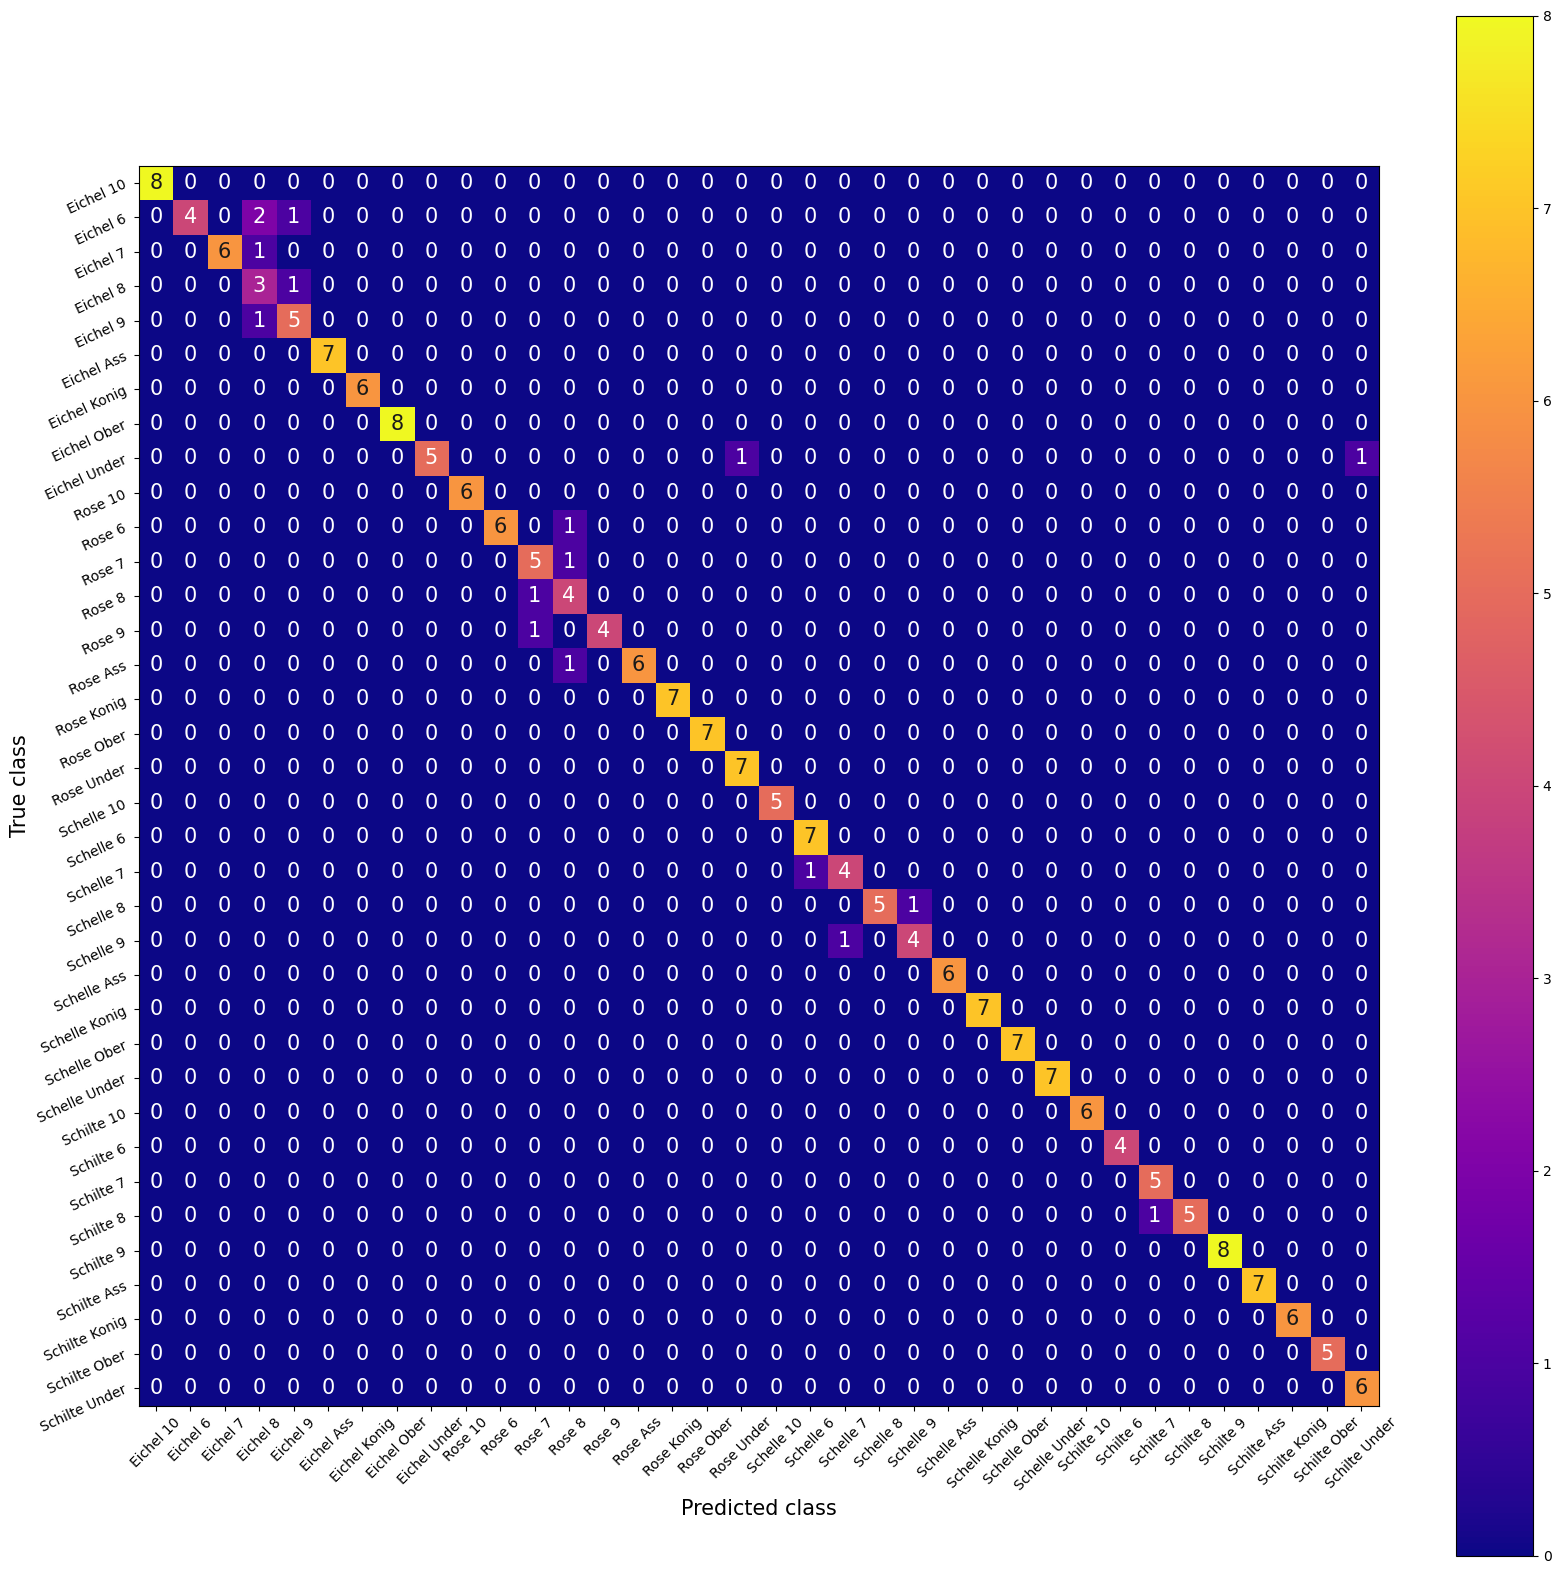

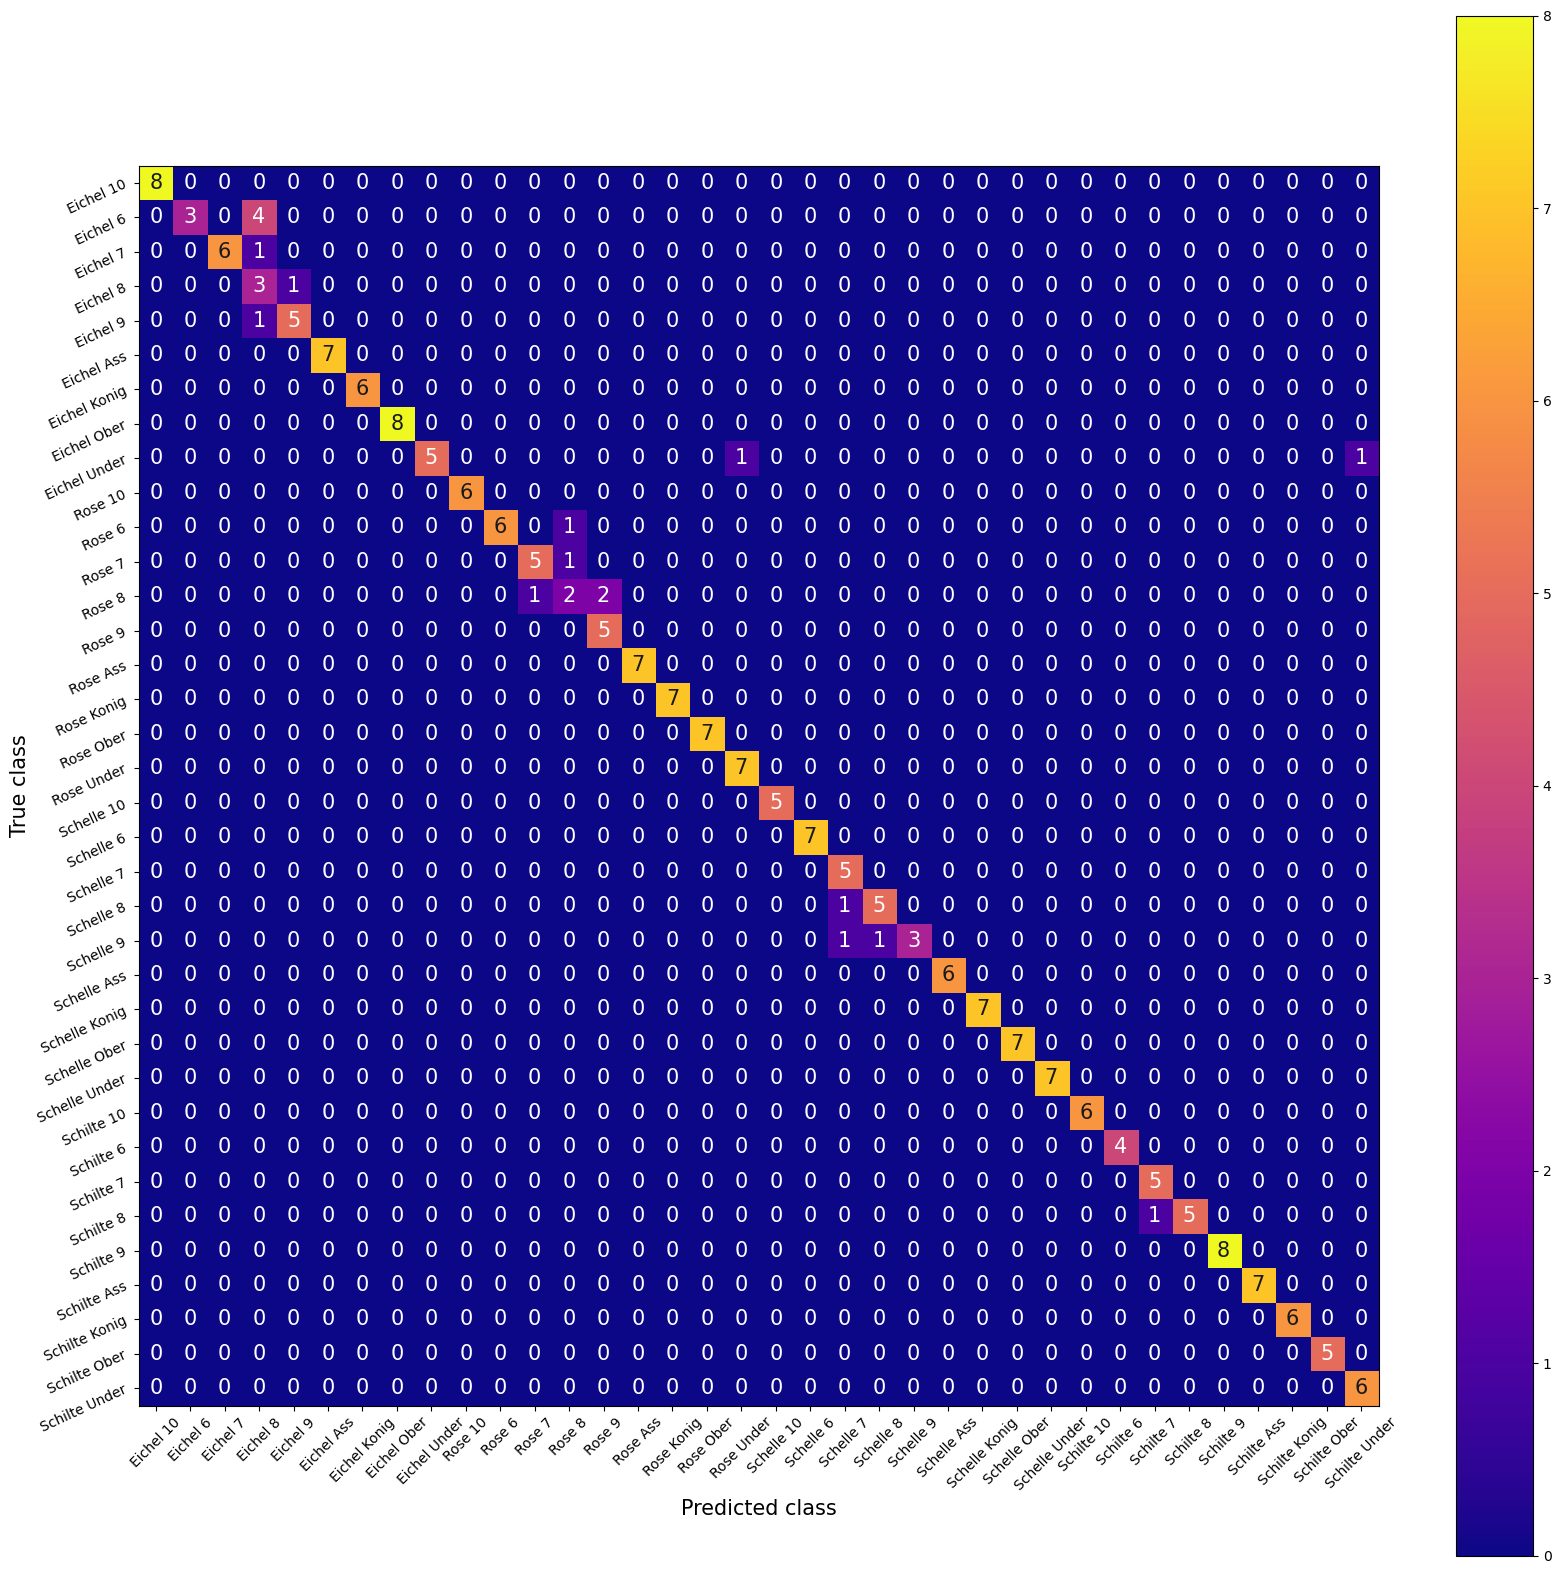

In [19]:
run_tests(checkpoints, "real")